# Synthetic data

In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm


In [2]:
from maelstrom import Maelstrom

In [3]:
xo.__version__

'0.2.0'

In [37]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, noise=0.05):
        # Add noise
        np.random.seed(42)
        self.flux_err = noise * np.std(self.flux_true)
        self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))
        
    @staticmethod
    def quick_star(self, star='dsct', mission='kepler'):
        """
        Don't use me. yet.
        """
        if star == 'dsct':
            pass

In [67]:
a = np.array([1,2,3])
np.append(a,a)

array([1, 2, 3, 1, 2, 3])

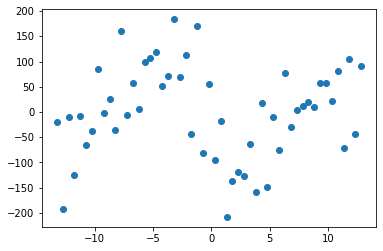

In [115]:
# Check time delay signal is injected properly
period = 15.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

n_freq = 22
np.random.seed(42)
freqs = np.random.normal(40, 20, size=n_freq)

np.random.seed(23)
amps = np.random.normal(0.001, 0.01, size=n_freq)

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
lc.add_noise(noise=1.)

ms = Maelstrom(lc.time, lc.flux, max_peaks=3)
td_time, td_td = ms.get_time_delay(segment_size=0.5)
plt.scatter(td_time, td_td[0])

In [116]:
ms.freq

array([50.84993113, 21.83932971, 30.61356152])

(0, 80)

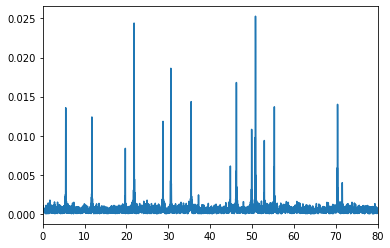

In [117]:
#plt.plot(lc.time, lc.flux)
plt.plot(*amp_spectrum(lc.time, lc.flux))
plt.xlim(0,80)

Some convenience functions

In [16]:
from astropy.stats import LombScargle
from astropy.convolution import convolve, Box1DKernel
import math

def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    
    return freq, amp


def smooth(freq, power, method='boxkernel', filter_width=0.1):

    if method == 'boxkernel':
        if filter_width <= 0.:
            raise ValueError("the `filter_width` parameter must be "
                             "larger than 0 for the 'boxkernel' method.")
        fs = np.mean(np.diff(freq))
        box_kernel = Box1DKernel(math.ceil((filter_width/fs)))
        smooth_power = convolve(power, box_kernel)
        return smooth_power

    if method == 'logmedian':
        count = np.zeros(len(freq), dtype=int)
        bkg = np.zeros_like(freq)
        x0 = np.log10(freq[0])
        while x0 < np.log10(freq[-1]):
            m = np.abs(np.log10(freq) - x0) < filter_width
            if len(bkg[m] > 0):
                bkg[m] += np.nanmedian(power)
                count[m] += 1
            x0 += 0.5 * filter_width
        bkg /= count
        smooth_power = bkg
        return smooth_power

Now, iterate over an array of light curves with different noises, calculating the SNR and log probability in each light curve. Note multiprocessing doesn't work here.. It seems that Theano can't simultaneously compile two models. If you have a good workaround I'd love to see it

In [7]:
from tqdm import tqdm as tqdm

snr = []
logp = []
noises = np.arange(0.,5.,0.1)

period = 20.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

freqs = [50]
amps = [0.001]
time = np.arange(0, 27, 1.0 / (24 * 30))

for noise in tqdm(noises):
    lc = SyntheticBinary(time, freqs,amps,
                         period, eccen, asini, varpi, tref)

    lc.add_noise(noise=noise)

    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr.append(np.max(val))
    
    ms = Maelstrom(lc.time, lc.flux, freq=np.array([50]))
    ms.setup_orbit_model(period=20.)
    opt = ms.optimize(verbose=False)
    logp.append(ms.logp(opt))

100%|██████████| 50/50 [17:59<00:00, 21.70s/it]


We plot the SNR of the frequency vs the log probability of the model after optimizing. I'm not sure why there's a big discontinuity near SNR 300, but the earlier stuff looks OK

(4.838995822862638, 5.2)

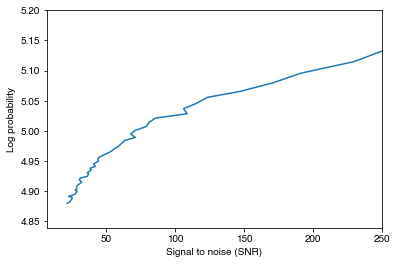

In [11]:
plt.plot(snr, np.log10(logp))
plt.xlabel('Signal to noise (SNR)')
plt.ylabel('Log probability')
plt.xlim(None,250)
plt.ylim(None,5.2)

# Hessian

In [7]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import exoplanet as xo
xo.__version__

'0.1.6'

# Varying noise

In [8]:
import tqdm
snr, std_hess = [], []
amps = [0.001]
nu_arr = np.array([50])
noises = np.geomspace(0.1,10,20)
#noises = [2,5,100]
time_t = np.arange(0, 27, 1.0 / (24 * 30))

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for noise in tqdm.tqdm(noises):
    time_t = np.arange(0, 27, 1.0 / (24 * 30))
    
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    lc.add_noise(noise=noise)
    # Calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr.append(np.max(val))
    
    t = lc.time
    y = lc.flux
    ms = Maelstrom(t,y, freq=nu_arr)
    td_time, td_td = ms.get_time_delay(segment_size=1.)
    td_td = np.average(td_td, axis=0)
    td_time = np.array(td_time + ms.time_mid)

    with pm.Model() as model:
        # Parameters
        #period = pm.Normal("period", mu=1000., sd=.)
        period = pm.Normal("period", mu=period_t, sd=5.)
        #period = pm.Uniform('period', lower=1., upper=15., testval=10.)
        tref = 0.#pm.Normal("tref", mu=0., sd=5.)
        varpi = 1.#pm.Normal("varpi", mu=1., sd=5.)
        eccen = 0.5#pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.5)
        #logs = pm.Normal('logs', mu=np.log(np.std(y)), sd=10)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = pm.Normal('lighttime', mu=asini_t, sd=5.)
        #lighttime = pm.Uniform('lighttime', lower=50, upper=150, testval=100.)

        # Deterministic transformations
        # Mean anom
        M = 2.0 * np.pi * (tt.constant(td_time) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        factor = 1.0 - tt.square(eccen)
        factor /= 1.0 + eccen * tt.cos(f)
        psi = -factor * tt.sin(f + varpi)

        tau = lighttime * psi
        taumodel = tau - tt.mean(tau)

        # Condition on the observations
        pm.Normal("obs_photometry", mu=taumodel, sd=1., observed=td_td)
    
        #map_soln = pm.find_MAP(progressbar=False)
        map_soln = {
            'period': np.array(10.),
            'lighttime': np.array(100.),
        }
        #plt.plot(td_time, xo.eval_in_model(taumodel, map_soln))
        #plt.scatter(td_time, td_td)
        #map_soln = {'period': np.array(period_t)}
        
        hess = pm.find_hessian(map_soln, model=model)
        std_hess.append(np.diagonal((1/np.abs(hess))**0.5)[0])
        
        #print(np.max(val), np.diagonal((1/np.abs(hess))**0.5))
        
        #plt.plot(td_time, td_td)
        #plt.plot(td_time, xo.eval_in_model(taumodel, map_soln))

100%|██████████| 20/20 [03:15<00:00,  8.96s/it]


Text(0, 0.5, 'Log period sigma')

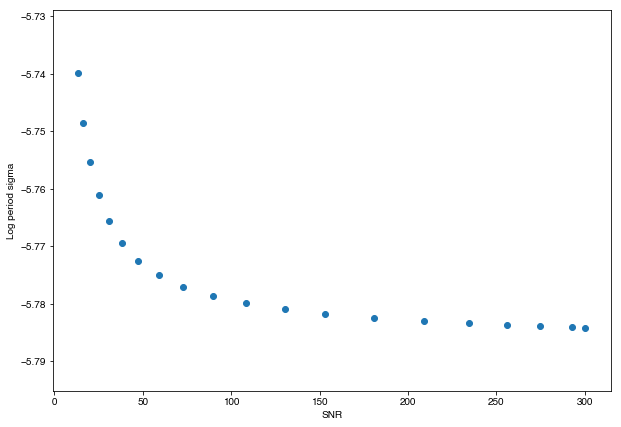

In [31]:
std_hess = np.array(std_hess)
plt.figure(figsize=[10,7])
plt.scatter(snr, np.log(std_hess))
plt.xlabel('SNR')
plt.ylabel('Log period sigma')

## Compare to maelstrom

Text(0.5, 0, 'Noise')

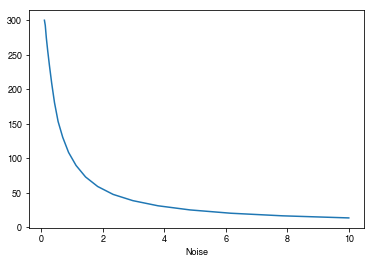

In [222]:
plt.plot(noises, snr)
plt.xlabel('Noise')

In [223]:
noises, snr

(array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
         0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
         1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
         3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]),
 [300.33771737598255,
  293.05881052001786,
  274.66451306400313,
  256.050848746171,
  234.496352318444,
  209.0871893420948,
  180.6966428531121,
  153.27153398949065,
  130.49499069663662,
  108.48751806719504,
  89.59096088849134,
  72.88265766328102,
  59.01860995957358,
  47.548380388717995,
  38.50351154782286,
  31.064288278238582,
  25.05436502274774,
  20.248226787140517,
  16.474630249205564,
  13.436720833793112])

In [98]:
noises = np.geomspace(0.1,10,20)
#noises = [2,5,100]
time_t = np.arange(0, 27, 1.0 / (24 * 30))

snr_mael = []
hess_mael = []

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for noise in tqdm.tqdm(noises):
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    lc.add_noise(noise=noise)
    # Calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr_mael.append(np.max(val))
    
    t = lc.time
    y = lc.flux

    with pm.Model() as model:
        # Parameters
        period = pm.Normal("period", mu=period_t, sd=5.)
        tref = tref_t#pm.Uniform("tref", lower=-50000, upper=50000)
        varpi = 1.#pm.Uniform("varpi", lower=1e-2, upper=10)
        eccen = eccen_t#pm.Uniform("eccen", lower=1e-11, upper=0.99)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = asini_t#pm.Normal('lighttime', mu=asini_t, sd=1.)

        # Mean anom
        M = 2.0 * np.pi * (tt.constant(t) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))

        # tau in d
        tau = (lighttime) * psi[:,None]
        tau /= 86400.

        arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
        D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
        DTD = tt.dot(D.T,D)
        DTy = tt.dot(D.T, y[:, None])
        W_hat = tt.slinalg.solve(DTD, DTy)

        model_tensor = tt.squeeze(tt.dot(D,W_hat))

        # Sue me again
        model_tensor = model_tensor

        # Condition on the observations
        pm.Normal("obs", mu=model_tensor, sd=None, observed=y)

        #plt.scatter(t,y, 10, c='blue')
        #plt.plot(t, xo.eval_in_model(model_tensor), c='r', alpha=0.5)
        #plt.xlim(0,0.2)

        map_soln = pm.find_MAP()
        #map_soln = {
        #    'period': np.array(period_t)
        #}
        hess = pm.find_hessian(map_soln, model=model)
        hess_mael.append(np.diagonal((1/np.abs(hess))**0.5)[0])

  0%|          | 0/20 [00:00<?, ?it/s]/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')

  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -17,867, ||grad|| = 1.9989e-07:   0%|          | 0/5000 [00:00<?, ?it/s]
  5%|▌         | 1/20 [00:09<03:02,  9.61s/it]████████| 2/2 [00:00<00:00, 69.30it/s]/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() a

In [100]:
normed_mael = (hess_mael-min(hess_mael))/(max(hess_mael)-min(hess_mael))
normed_hess = (std_hess-min(std_hess))/(max(std_hess)-min(std_hess))

In [224]:
red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

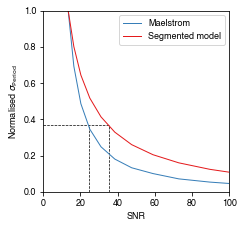

In [228]:
hess_mael = np.array(hess_mael)
fig, ax = plt.subplots(figsize=mnras_size(240., square=True))
ax.plot(snr_mael, normed_mael, '-', c=blue, label='Maelstrom', linewidth=1)
ax.plot(snr, normed_hess, '-', c=red, label='Segmented model', linewidth=1)
ax.set_xlabel('SNR')
ax.set_ylabel(r'Normalised $\sigma_{\rm Period}$')
plt.legend()

one_e = 0.36787944117144233
ax.hlines(one_e, xmin=0, xmax=35.5, linestyles='dashed', linewidth=0.7)
ax.vlines(24.5, ymin=0, ymax=one_e, linestyles='dashed', linewidth=0.7)
ax.vlines(35.5, ymin=0, ymax=one_e, linestyles='dashed', linewidth=0.7)
#plt.axhline(0.36787944117144233, xmin=0, xmax=0.08)
#plt.savefig('interesting.png', dpi=300)
ax.set_xlim(0,100)
ax.set_ylim(0,1.)
plt.savefig('/Users/danielhey/Dropbox (Sydney Uni)/Apps/Overleaf/Maelstrom/figs/period_uncertainty.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [215]:
import matplotlib
matplotlib.rcParams["font.size"] = 9.

def mnras_size(fig_width_pt, square=False):
    #Paper width = 597.5  for 2 columns or 504?
    #Col width = 240.0    #for single column
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

In [146]:
# -*- coding: utf-8 -*-

from __future__ import division, print_function

from cycler import cycler
from matplotlib import rcParams
try:
    from savefig import monkey_patch
except ImportError:
    def monkey_patch(include_diff=False):
        pass

__all__ = ["setup", "get_figsize", "COLORS", "COLOR_CYCLE", "SQUARE_FIGSIZE"]

__savepath__ = ['test']
COLOR_CYCLE = (
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
)

COLORS = dict(
    DATA="k",
    MODEL_1="#1f77b4",
    MODEL_2="#ff7f0e",
)

def setup(auto=False):
    monkey_patch()
    rcParams["font.size"] = 12
    rcParams["font.family"] = "helvetica"
    #rcParams["font.sans-serif"] = ["Computer Modern Sans"]
    rcParams["text.usetex"] = False
    #rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
    if auto:
        rcParams["figure.autolayout"] = True
    rcParams["axes.prop_cycle"] = cycler("color", COLOR_CYCLE)

def get_figsize(rows=1, cols=1):
    return (4 * cols, 4 * rows)


SQUARE_FIGSIZE = get_figsize(1, 1)

In [147]:
setup()

Text(0, 0.5, 'Log period sigma')

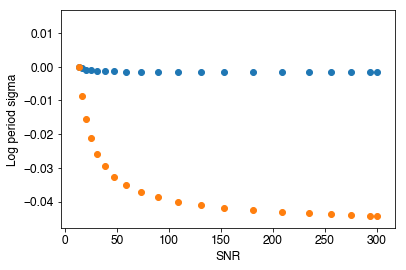

In [148]:
hess_mael = np.array(hess_mael)
plt.scatter(snr_mael, np.log(hess_mael/np.max(hess_mael)))
plt.scatter(snr, np.log(std_hess/np.max(std_hess)))
plt.xlabel('SNR')
plt.ylabel('Log period sigma')

In [29]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [period]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:51<00:00, 58.65draws/s]


In [30]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,9.98576,1.01259,0.033251,8.025867,11.974221,818.207274,1.00084


In [32]:
map_soln

{'period': array(10.)}

# Meshgrid

In [91]:

time_t = np.arange(0, 27, 1.0 / (24 * 30))

snr_mael = []
hess_mael = []

period_t = 10#np.linspace(1., 27/2, 5)
eccen_t = 0.5
asinis = np.linspace(10., 200, 1)
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for asini_t in tqdm.tqdm(asinis):
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    t = lc.time
    y = lc.flux

    with pm.Model() as model:
        # Parameters
        period = period_t#pm.Normal("period", mu=period_t, sd=5.)
        tref = tref_t#pm.Uniform("tref", lower=-50000, upper=50000)
        varpi = 1.#pm.Uniform("varpi", lower=1e-2, upper=10)
        eccen = eccen_t#pm.Uniform("eccen", lower=1e-11, upper=0.99)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = pm.Normal('lighttime', mu=5, sd=1.)

        # Mean anom
        M = 2.0 * np.pi * (tt.constant(t) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))

        # tau in d
        tau = (lighttime) * psi[:,None]
        tau /= 86400.


        arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
        D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
        DTD = tt.dot(D.T,D)
        DTy = tt.dot(D.T, y[:, None])
        W_hat = tt.slinalg.solve(DTD, DTy)

        model_tensor = tt.squeeze(tt.dot(D,W_hat))

        # Sue me again
        model_tensor = model_tensor

        # Condition on the observations
        pm.Normal("obs", mu=model_tensor, sd=None, observed=y)

        #plt.scatter(t,y, 10, c='blue')
        #plt.plot(t, xo.eval_in_model(model_tensor), c='r', alpha=0.5)
        #plt.xlim(0,0.2)

        map_soln = pm.find_MAP()
        #map_soln = {'lighttime': np.array(asini_t)}
        hess = pm.find_hessian(map_soln, model=model)
        hess_mael.append(np.diagonal((1/(hess))**0.5)[0])

  0%|          | 0/1 [00:00<?, ?it/s]/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')

  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -17,865, ||grad|| = 5.5809e-07:   0%|          | 0/5000 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:04<00:00,  4.00s/it]█████████| 2/2 [00:00<00:00, 211.77it/s]


In [92]:
map_soln, hess_mael

({'lighttime': array(5.)}, [0.999999944203181])

In [93]:
with model:
    trace = pm.sample(1000)
    pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lighttime]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 214.62draws/s]


In [94]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lighttime,5.01222,0.983945,0.03184,3.131228,7.005652,827.588327,0.999613


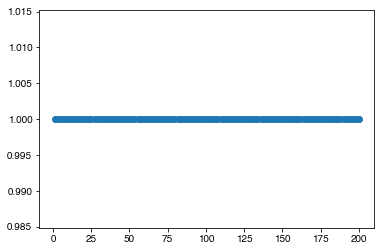

In [80]:
plt.scatter(asinis,hess_mael)

# Varying period

In [72]:
import tqdm
snr, std_hess = [], []
amps = [0.001]
nu_arr = np.array([50])
#noises = [2,5,100]
time_t = np.arange(0, 27, 1.0 / (24 * 30))

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for ff in tqdm.tqdm(nu_arr):
    time_t = np.arange(0, 27, 1.0 / (24 * 30))
    
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    t = lc.time
    y = lc.flux
    ms = Maelstrom(t,y, freq=[ff])
    td_time, td_td = ms.get_time_delay(segment_size=1.)
    td_td = np.average(td_td, axis=0)
    td_time = np.array(td_time + ms.time_mid)

    with pm.Model() as model:
        # Parameters
        #period = pm.Normal("period", mu=1000., sd=.)
        period = pm.Normal("period", mu=period_t, sd=5.)
        #period = pm.Uniform('period', lower=1., upper=15., testval=10.)
        tref = 0.#pm.Normal("tref", mu=0., sd=5.)
        varpi = 1.#pm.Normal("varpi", mu=1., sd=5.)
        eccen = 0.5#pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.5)
        #logs = pm.Normal('logs', mu=np.log(np.std(y)), sd=10)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = 100.#pm.Normal('lighttime', mu=asini_t, sd=5.)
        #lighttime = pm.Uniform('lighttime', lower=50, upper=150, testval=100.)

        # Deterministic transformations
        # Mean anom
        M = 2.0 * np.pi * (tt.constant(td_time) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        factor = 1.0 - tt.square(eccen)
        factor /= 1.0 + eccen * tt.cos(f)
        psi = -factor * tt.sin(f + varpi)

        tau = lighttime * psi
        taumodel = tau - tt.mean(tau)

        # Condition on the observations
        pm.Normal("obs_photometry", mu=taumodel, sd=1., observed=td_td)
    
        #map_soln = pm.find_MAP(progressbar=False)
        map_soln = {
            'period': np.array(10.),
        }
        
        hess = pm.find_hessian(map_soln, model=model)
        std_hess.append(np.diagonal((1/np.abs(hess))**0.5)[0])
        
        #print(np.max(val), np.diagonal((1/np.abs(hess))**0.5))
        
        #plt.plot(td_time, td_td)
        #plt.plot(td_time, xo.eval_in_model(taumodel, map_soln))

100%|██████████| 20/20 [03:06<00:00,  9.54s/it]


In [9]:

amps = [0.001]
nu_arr = np.array([50])
noises = np.geomspace(0.1,10,20)
#noises = [2,5,100]
time_t = np.arange(0, 27, 1.0 / (24 * 30))

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
time_t = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time_t, nu_arr,amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)

t = lc.time
y = lc.flux
ms = Maelstrom(t,y, freq=nu_arr)
td_time, td_td = ms.get_time_delay(segment_size=1.)
td_td = np.average(td_td, axis=0)
td_time = np.array(td_time)

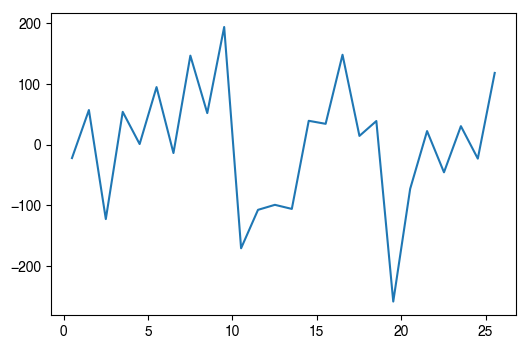

In [71]:
plt.plot(td_time, td_td)

In [211]:
time_t = np.arange(0, 27, 1.0 / (24 * 30))
(time_t[0] + time_t[-1])/ 2

13.499305555555557

In [205]:
time_t

array([-13.49930556, -13.49791667, -13.49652778, ...,  13.49652778,
        13.49791667,  13.49930556])

In [183]:
np.pi

3.141592653589793

In [208]:
a = {
    'period': np.array([20.]),
    'tref': np.array([0.]),
    'varpi': np.array([1.]),
    'logs': np.array([0]),
    'lighttime': np.array([100.]),
    'eccen': np.array(0.5),
}

In [230]:
period = 15.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

time = np.arange(0, 27, 1.0 / (24 * 30))
lc = SyntheticBinary(time, freqs,amps,
                     period, eccen, asini, varpi, tref)


t = lc.time
y = lc.flux

ms = Maelstrom(t,y, freq=np.array([50]))
td_time, td_td = ms.get_time_delay(segment_size=1.)
td_td = np.average(td_td, axis=0)
td_time = np.array(td_time)


with pm.Model() as model:
    # Parameters
    #period = pm.Normal("period", mu=1000., sd=.)
    period = pm.Normal("period", mu=15., sd=1.)
    tref = 0.#pm.Normal("tref", mu=0., sd=5.)
    varpi = 1.#pm.Normal("varpi", mu=1., sd=5.)
    eccen = 0.5#pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.5)
    logs = 0.#pm.Normal('logs', mu=np.log(np.std(y)), sd=10)
    #jitter = pm.Uniform('jitter', lower=0, upper=10)
    lighttime = pm.Normal('lighttime', mu=100., sd=5.)

    # Deterministic transformations
    # Mean anom
    M = 2.0 * np.pi * (td_time - tref) / period
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))

    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * tt.cos(f)
    psi = -factor * tt.sin(f + varpi)

    tau =  lighttime * psi
    taumodel = tau - tt.mean(tau)

    # Condition on the observations
    pm.Normal("obs_photometry", mu=taumodel, sd=1., observed=td_td)

    map_soln = pm.find_MAP()

    #plt.plot(td_time, xo.eval_in_model(taumodel, map_soln))
    #plt.scatter(td_time, td_td)

    #hess = pm.find_hessian(a)
    #print(np.diagonal((1/hess)**0.5))

/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')

  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -1.5832e+05, ||grad|| = 3,906.4:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -1.7501e+06, ||grad|| = 1,839.6:   0%|          | 10/5000 [00:00<00:03, 1268.04it/s]
logp = -40,734, ||grad|| = 410.2:   0%|          | 20/5000 [00:00<00:03, 1615.90it/s]      
logp = -11,366, ||grad|| = 645.5:   1%|          | 30/5000 [00:00<00:02, 1765.33it/s]
logp = -11,366, ||grad|| = 645.5: 100%|██████████| 37/37 [00:00<00:00, 1455.03it/s]  

In [231]:
map_soln

{'period': array(-21.8503458), 'lighttime': array(-95.72275455)}

In [240]:
%timeit pm.find_hessian(map_soln, model=model, vars=[period])

4.26 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [217]:
pm.find_hessian_diag(map_soln, model=model)

AttributeError: module 'pymc3' has no attribute 'find_hessian_diag'

In [117]:
# Let's be a little more clever about the optimization:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[lighttime, t0])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[period, t0])
    map_soln = xo.optimize(start=map_soln, vars=[eccen])
    map_soln = xo.optimize(start=map_soln, vars=[period, t0])
    map_soln = xo.optimize(start=map_soln, vars=[lighttime])
    map_soln = xo.optimize(start=map_soln, vars=[eccen])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['W_hat_sin', 'W_hat_cos', 'mean_flux']
message: Optimization terminated successfully.
logp: 61903.090989495686 -> 71077.96065718326
optimizing logp for variables: ['W_hat_sin', 'W_hat_cos', 'mean_flux', 'logs']
message: Desired error not necessarily achieved due to precision loss.
logp: 71077.96065718326 -> 89905.59409611185
optimizing logp for variables: ['t0', 'lighttime']
message: Optimization terminated successfully.
logp: 89905.59409611185 -> 98483.8476194079
optimizing logp for variables: ['W_hat_sin', 'W_hat_cos', 'mean_flux', 'logs']
message: Desired error not necessarily achieved due to precision loss.
logp: 98483.8476194079 -> 117672.57089661049
optimizing logp for variables: ['t0', 'period']
message: Optimization terminated successfully.
logp: 117672.57089661049 -> 117983.62318613713
optimizing logp for variables: ['eccen_interval__']
message: Optimization terminated successfully.
logp: 117983.62318613713 -> 118020.4407715362
optimizing logp f

In [118]:
hess = pm.find_hessian(map_soln, model=model)
np.diagonal((1/hess)**0.5)

array([3.94583362e-10, 3.30839784e-10, 1.08340854e-09, 6.95648666e-10,
       2.20058658e-10, 6.45082573e-03, 9.15080254e-09, 2.69741031e-13,
       3.81479857e-13, 3.81462993e-13])

In [119]:
map_soln

{'period': array(20.00000005),
 't0': array(0.54411447),
 'varpi_angle__': array([4.06390048, 2.60940061]),
 'eccen_interval__': array(1.03558725e-08),
 'logs': array(-24.00377),
 'lighttime': array(99.9999996),
 'mean_flux': array(-8.19926442e-12),
 'W_hat_cos': array([0.01]),
 'W_hat_sin': array([0.01]),
 'varpi': array(0.99999998),
 'eccen': array(0.5),
 'tref': array(-8.39282744e-08)}

In [45]:
model.fastdlogp()

In [247]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [248]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    opt = pm.find_MAP()
    hess = pm.find_hessian(opt)
    #print((1/pm.find_hessian(opt))**0.5)

/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1290.24it/s]  


In [256]:
np.sqrt(np.diag(np.linalg.inv(hess)))

array([0.09634077, 0.08536588, 0.49584104, 0.07006408])

In [249]:
np.diag((1/hess)**0.5)

array([0.09629439, 0.0853254 , 0.49564788, 0.07006396])

In [257]:
1/hess

array([[ 9.27261010e-03,  3.42079931e-01, -2.37348432e+00,
         5.60134977e+01],
       [ 3.42079931e-01,  7.28042351e-03, -2.14161137e+00,
         5.20348778e+01],
       [-2.37348432e+00, -2.14161137e+00,  2.45666816e-01,
         1.91770583e+01],
       [ 5.60134977e+01,  5.20348778e+01,  1.91770583e+01,
         4.90895902e-03]])

In [250]:
with basic_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 1874.12draws/s]


In [251]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.906601,0.099057,0.000952,0.712466,1.100688,12312.217947,0.999902
beta__0,0.948307,0.089552,0.000721,0.770308,1.123871,15178.445236,1.000024
beta__1,2.607862,0.513537,0.004041,1.587409,3.600222,14615.029193,0.999923
sigma,0.990940,0.071003,0.000554,0.854748,1.126497,14790.701859,0.999900


In [96]:
(1/hess)**0.5

array([[0.09629439, 0.584876  ,        nan, 7.48421657],
       [0.584876  , 0.0853254 ,        nan, 7.21352049],
       [       nan,        nan, 0.49564788, 4.37916182],
       [7.48421657, 7.21352049, 4.37916182, 0.07006396]])

In [89]:
hess.shape

(4, 4)

In [75]:
np.sqrt(-0.25)

nan

In [70]:
pm.find_hessian?

In [31]:
- (1/4.01)

-0.24937655860349128

In [21]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

In [14]:
lc = SyntheticBinary(time, freqs,amps,
                         period, eccen, asini, varpi, tref)

lc.add_noise(noise=noise)

freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
val = amp / smoothed
snr.append(np.max(val))

ms = Maelstrom(lc.time, lc.flux, freq=np.array([50]))
ms.setup_orbit_model(period=20.)
opt = ms.optimize(verbose=False)

In [20]:
pm.find_hessian(opt, model=ms)

KeyboardInterrupt: 

In [18]:
with ms:
    pm.find_hessian(opt)

KeyboardInterrupt: 

In [17]:
with ms:
    std_q = ((1/pm.find_hessian(opt))**0.5)[0]
    print(std_q)

KeyboardInterrupt: 

In [12]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1, transform=None)
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q))**0.5)[0]
print(mean_q['p'], std_q)

/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 6: 100%|██████████| 3/3 [00:00<00:00, 593.23it/s]


1.5 [inf]


In [ ]:
import numpy
import theano
import theano.tensor as T
from theano import pp
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
pp(gy)  # print out the gradient prior to optimization
'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'
f = theano.function([x], gy)
f(4)
array(8.0)
numpy.allclose(f(94.2), 188.4)
True


In [ ]:


x = T.dvector('x')
y = x ** 2
cost = y.sum()
gy = T.grad(cost, x)
H, updates = theano.scan(lambda i, gy,x : T.grad(gy[i], x), sequences=T.arange(gy.shape[0]), non_sequences=[gy, x])
f = theano.function([x], H, updates=updates)
f([4, 4])
array([[ 2.,  0.],
       [ 0.,  2.]])

Other stuff; the meshgrid of period and asini.

In [74]:
period = np.arange(1,27,1)
asini = np.arange(1,100, 5)

In [34]:
from tqdm import tqdm_notebook as tqdm
time = np.arange(0, 27, 1.0 / (24 * 30))
logp = []
for p in period:
    for a in tqdm(asini):
        eccen = 0.5
        varpi = 1.
        tref = 0.

        n_freqs = 1
        freqs = [50]
        amps = [1]
        

        lc = SyntheticBinary(time, freqs,amps,
                             p, eccen, a, varpi, tref)
        
        ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
               #max_peaks=1
              )
        ms.setup_orbit_model(period=p)
        opt = ms.optimize()
        logp.append(ms.logp(opt))

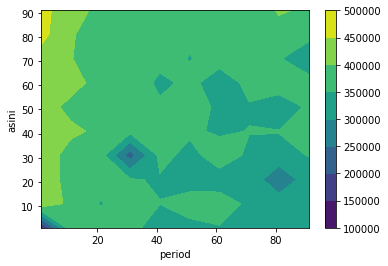

In [70]:
plt.contourf(period, asini, new_logp.reshape(len(period), len(asini)))
plt.xlabel('period')
plt.ylabel('asini')
plt.colorbar()